#### A soft introduction to deep autoencoders in Jax

In [1]:
 ## Standard libraries
import os
import json
import math
import numpy as np
from scipy import spatial

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

## PyTorch Data Loading
import torch
import torch.utils.data as data
import torchvision
from torchvision.datasets import CIFAR10

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../../saved_models/tutorial9_jax"

print("Device:", jax.devices()[0])

<ipython-input-1-9f697e861957>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: TFRT_CPU_0


In [2]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/JAX/tutorial9/"
# Files to download
pretrained_files = ["cifar10_64.ckpt", "cifar10_128.ckpt", "cifar10_256.ckpt", "cifar10_384.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please contact the author with the full output including the following error:\n", e)

In [3]:
# Transformations applied on each image => bring them into a numpy array
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    if img.max() > 1:
        img = img / 255. * 2. - 1.
    return img

# For visualization, we might want to map JAX or numpy tensors back to PyTorch
def jax_to_torch(imgs):
    imgs = jax.device_get(imgs)
    imgs = torch.from_numpy(imgs.astype(np.float32))
    imgs = imgs.permute(0, 3, 1, 2)
    return imgs

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=image_to_numpy, download=True)
train_set, val_set = data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=image_to_numpy, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4, collate_fn=numpy_collate, persistent_workers=True)
val_loader = data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4, collate_fn=numpy_collate)
test_loader = data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4, collate_fn=numpy_collate)

100%|██████████| 170498071/170498071 [00:12<00:00, 13662917.33it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [4]:
class Encoder(nn.Module):
    c_hid : int
    latent_dim : int

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 32x32 => 16x16
        x = nn.gelu(x)
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 16x16 => 8x8
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3), strides=2)(x)  # 8x8 => 4x4
        x = nn.gelu(x)
        x = x.reshape(x.shape[0], -1)  # Image grid to single feature vector
        x = nn.Dense(features=self.latent_dim)(x)
        return x

In [5]:
## Test encoder implementation
# Random key for initialization
rng = random.PRNGKey(0)
# Example images as input
imgs = next(iter(train_loader))[0]
# Create encoder
encoder = Encoder(c_hid=32, latent_dim=128)
# Initialize parameters of encoder with random key and images
params = encoder.init(rng, imgs)['params']
# Apply encoder with parameters on the images
out = encoder.apply({'params': params}, imgs)
out.shape

del out, encoder, params

In [6]:
class Decoder(nn.Module):
    c_out : int
    c_hid : int
    latent_dim : int

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=2*16*self.c_hid)(x)
        x = nn.gelu(x)
        x = x.reshape(x.shape[0], 4, 4, -1)
        x = nn.ConvTranspose(features=2*self.c_hid, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=2*self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.ConvTranspose(features=self.c_hid, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.gelu(x)
        x = nn.Conv(features=self.c_hid, kernel_size=(3, 3))(x)
        x = nn.gelu(x)
        x = nn.ConvTranspose(features=self.c_out, kernel_size=(3, 3), strides=(2, 2))(x)
        x = nn.tanh(x)
        return x

In [7]:
## Test decoder implementation
# Random key for initialization
rng = random.PRNGKey(0)
# Example latents as input
rng, lat_rng = random.split(rng)
latents = random.normal(lat_rng, (16, 128))
# Create decoder
decoder = Decoder(c_hid=32, latent_dim=128, c_out=3)
# Initialize parameters of decoder with random key and latents
rng, init_rng = random.split(rng)
params = decoder.init(init_rng, latents)['params']
# Apply decoder with parameters on the images
out = decoder.apply({'params': params}, latents)
out.shape

del out, decoder, params

In [8]:
class Autoencoder(nn.Module):
    c_hid: int
    latent_dim : int

    def setup(self):
        # Alternative to @nn.compact -> explicitly define modules
        # Better for later when we want to access the encoder and decoder explicitly
        self.encoder = Encoder(c_hid=self.c_hid, latent_dim=self.latent_dim)
        self.decoder = Decoder(c_hid=self.c_hid, latent_dim=self.latent_dim, c_out=3)

    def __call__(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

In [9]:
## Test Autoencoder implementation
# Random key for initialization
rng = random.PRNGKey(0)
# Example images as input
imgs = next(iter(train_loader))[0]
# Create encoder
autoencoder = Autoencoder(c_hid=32, latent_dim=128)
# Initialize parameters of encoder with random key and images
params = autoencoder.init(rng, imgs)['params']
# Apply encoder with parameters on the images
out = autoencoder.apply({'params': params}, imgs)
out.shape

del out, autoencoder, params

In [10]:
def mse_recon_loss(model, params, batch):
    imgs, _ = batch
    recon_imgs = model.apply({'params': params}, imgs)
    loss = ((recon_imgs - imgs) ** 2).mean(axis=0).sum()  # Mean over batch, sum over pixels
    return loss

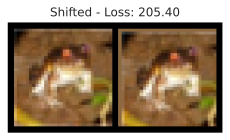

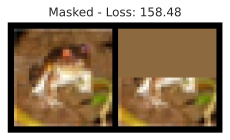

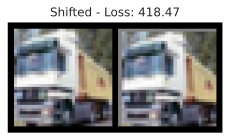

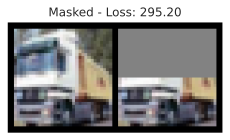

In [11]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss = ((img1 - img2) ** 2).sum()
    # Plot images for visual comparison
    imgs = jax_to_torch(np.stack([img1, img2], axis=0))
    grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4,2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(2):
    # Load example image
    img, _ = train_dataset[i]
    img_mean = img.mean(axis=(0,1), keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = np.roll(img, shift=SHIFT, axis=0)
    img_shifted = np.roll(img_shifted, shift=SHIFT, axis=1)
    img_shifted[:1,:,:] = img_mean
    img_shifted[:,:1,:] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = np.copy(img)
    img_masked[:img_masked.shape[1]//2,:,:] = img_mean
    compare_imgs(img, img_masked, "Masked -")


In [13]:
class GenerateCallback:

    def __init__(self, input_imgs, every_n_epochs=1):
        super().__init__()
        self.input_imgs = input_imgs  # Images to reconstruct during training
        self.every_n_epochs = every_n_epochs  # Only save those images every N epochs (otherwise tensorboard gets quite large)

    def log_generations(self, model, state, logger, epoch):
        if epoch % self.every_n_epochs == 0:
            reconst_imgs = model.apply({'params': state.params}, self.input_imgs)
            reconst_imgs = jax.device_get(reconst_imgs)

            # Plot and add to tensorboard
            imgs = np.stack([self.input_imgs, reconst_imgs], axis=1).reshape(-1, *self.input_imgs.shape[1:])
            imgs = jax_to_torch(imgs)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, value_range=(-1,1))
            logger.add_image("Reconstructions", grid, global_step=epoch)

In [14]:
class TrainerModule:

    def __init__(self, c_hid, latent_dim, lr=1e-3, seed=42):
        super().__init__()
        self.c_hid = c_hid
        self.latent_dim = latent_dim
        self.lr = lr
        self.seed = seed
        # Create empty model. Note: no parameters yet
        self.model = Autoencoder(c_hid=self.c_hid, latent_dim=self.latent_dim)
        # Prepare logging
        self.exmp_imgs = next(iter(val_loader))[0][:8]
        self.log_dir = os.path.join(CHECKPOINT_PATH, f'cifar10_{self.latent_dim}')
        self.generate_callback = GenerateCallback(self.exmp_imgs, every_n_epochs=50)
        self.logger = SummaryWriter(log_dir=self.log_dir)
        # Create jitted training and eval functions
        self.create_functions()
        # Initialize model
        self.init_model()

    def create_functions(self):
        # Training function
        def train_step(state, batch):
            loss_fn = lambda params: mse_recon_loss(self.model, params, batch)
            loss, grads = jax.value_and_grad(loss_fn)(state.params)  # Get loss and gradients for loss
            state = state.apply_gradients(grads=grads)  # Optimizer update step
            return state, loss
        self.train_step = jax.jit(train_step)
        # Eval function
        def eval_step(state, batch):
            return mse_recon_loss(self.model, state.params, batch)
        self.eval_step = jax.jit(eval_step)

    def init_model(self):
        # Initialize model
        rng = jax.random.PRNGKey(self.seed)
        rng, init_rng = jax.random.split(rng)
        params = self.model.init(init_rng, self.exmp_imgs)['params']
        # Initialize learning rate schedule and optimizer
        lr_schedule = optax.warmup_cosine_decay_schedule(
            init_value=0.0,
            peak_value=1e-3,
            warmup_steps=100,
            decay_steps=500*len(train_loader),
            end_value=1e-5
        )
        optimizer = optax.chain(
            optax.clip(1.0),  # Clip gradients at 1
            optax.adam(lr_schedule)
        )
        # Initialize training state
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=optimizer)

    def train_model(self, num_epochs=500):
        # Train model for defined number of epochs
        best_eval = 1e6
        for epoch_idx in tqdm(range(1, num_epochs+1)):
            self.train_epoch(epoch=epoch_idx)
            if epoch_idx % 10 == 0:
                eval_loss = self.eval_model(val_loader)
                self.logger.add_scalar('val/loss', eval_loss, global_step=epoch_idx)
                if eval_loss < best_eval:
                    best_eval = eval_loss
                    self.save_model(step=epoch_idx)
                self.generate_callback.log_generations(self.model, self.state, logger=self.logger, epoch=epoch_idx)
                self.logger.flush()

    def train_epoch(self, epoch):
        # Train model for one epoch, and log avg loss
        losses = []
        for batch in train_loader:
            self.state, loss = self.train_step(self.state, batch)
            losses.append(loss)
        losses_np = np.stack(jax.device_get(losses))
        avg_loss = losses_np.mean()
        self.logger.add_scalar('train/loss', avg_loss, global_step=epoch)

    def eval_model(self, data_loader):
        # Test model on all images of a data loader and return avg loss
        losses = []
        batch_sizes = []
        for batch in data_loader:
            loss = self.eval_step(self.state, batch)
            losses.append(loss)
            batch_sizes.append(batch[0].shape[0])
        losses_np = np.stack(jax.device_get(losses))
        batch_sizes_np = np.stack(batch_sizes)
        avg_loss = (losses_np * batch_sizes_np).sum() / batch_sizes_np.sum()
        return avg_loss

    def save_model(self, step=0):
        # Save current model at certain training iteration
        checkpoints.save_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, prefix=f'cifar10_{self.latent_dim}_', step=step)

    def load_model(self, pretrained=False):
        # Load model. We use different checkpoint for pretrained models
        if not pretrained:
            params = checkpoints.restore_checkpoint(ckpt_dir=self.log_dir, target=self.state.params, prefix=f'cifar10_{self.latent_dim}_')
        else:
            params = checkpoints.restore_checkpoint(ckpt_dir=os.path.join(CHECKPOINT_PATH, f'cifar10_{self.latent_dim}.ckpt'), target=self.state.params)
        self.state = train_state.TrainState.create(apply_fn=self.model.apply, params=params, tx=self.state.tx)

    def checkpoint_exists(self):
        # Check whether a pretrained model exist for this autoencoder
        return os.path.isfile(os.path.join(CHECKPOINT_PATH, f'cifar10_{self.latent_dim}.ckpt'))

In [15]:
def train_cifar(latent_dim):
    # Create a trainer module with specified hyperparameters
    trainer = TrainerModule(c_hid=32, latent_dim=latent_dim)
    if not trainer.checkpoint_exists():  # Skip training if pretrained model exists
        trainer.train_model(num_epochs=500)
        trainer.load_model()
    else:
        trainer.load_model(pretrained=True)
    test_loss = trainer.eval_model(test_loader)
    # Bind parameters to model for easier inference
    trainer.model_bd = trainer.model.bind({'params': trainer.state.params})
    return trainer, test_loss

In [16]:
model_dict = {}
for latent_dim in [64, 128, 256, 384]:
    trainer_ld, test_loss_ld = train_cifar(latent_dim)
    model_dict[latent_dim] = {"trainer": trainer_ld, "result": test_loss_ld}

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


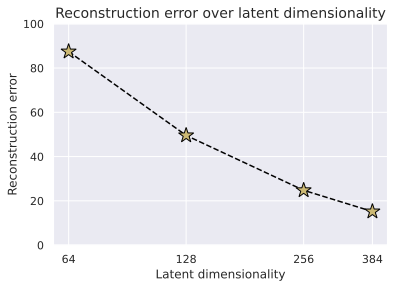

In [17]:
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]["result"] for k in latent_dims]

fig = plt.figure(figsize=(6,4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0,100)
plt.show()

In [18]:
def visualize_reconstructions(trainer, input_imgs):
    # Reconstruct images
    reconst_imgs = trainer.model_bd(input_imgs)
    imgs = np.stack([input_imgs, reconst_imgs], axis=1).reshape(-1, *reconst_imgs.shape[1:])

    # Plotting
    imgs = jax_to_torch(imgs)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7,4.5))
    plt.title(f"Reconstructed from {trainer.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

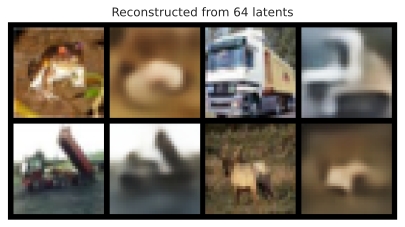

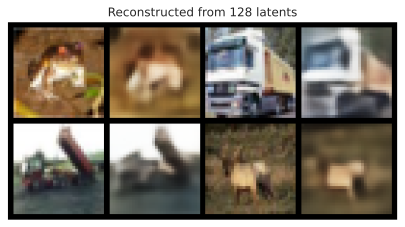

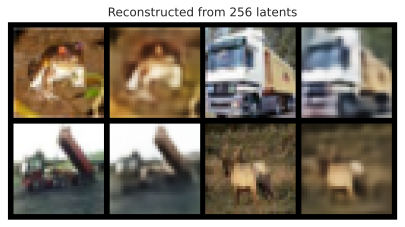

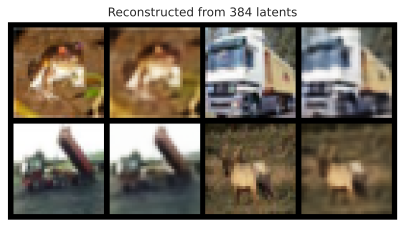

In [19]:
input_imgs = np.stack([image_to_numpy(train_dataset[i][0]) for i in range(4)], axis=0)
for latent_dim in model_dict:
    visualize_reconstructions(model_dict[latent_dim]["trainer"], input_imgs)

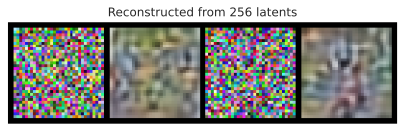

In [20]:
rng = jax.random.PRNGKey(123)
rgn, noise_rgn = jax.random.split(rng)
rand_imgs = jax.random.uniform(rng, (2, 32, 32, 3)) * 2 - 1
visualize_reconstructions(model_dict[256]["trainer"], rand_imgs)

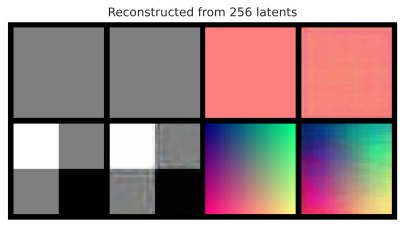

In [21]:
# JAX arrays are natively immutable. This is why we first create the images in numpy, and push them to JAX afterwards
plain_imgs = np.zeros((4, 32, 32, 3))

# Single color channel
plain_imgs[1,:,:,0] = 1
# Checkboard pattern
plain_imgs[2,:16,:16] = 1
plain_imgs[2,16:,16:] = -1
# Color progression
xx, yy = np.meshgrid(np.linspace(-1,1,32), np.linspace(-1,1,32), indexing='ij')
plain_imgs[3,:,:,0] = xx
plain_imgs[3,:,:,1] = yy

visualize_reconstructions(model_dict[256]["trainer"], plain_imgs)

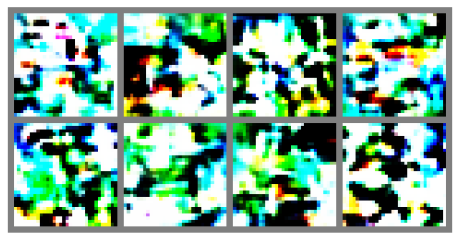

In [22]:
trainer = model_dict[256]["trainer"]
rgn, latent_noise = jax.random.split(rng)
latent_vectors = jax.random.normal(latent_noise, (8, trainer.latent_dim))
# Decode images -> Run model.decode method of the trainer's model with given parameters
imgs = trainer.model_bd.decoder(latent_vectors) # nn.apply(lambda model: model.decode(latent_vectors), trainer.model)({'params': trainer.state.params})

imgs = jax_to_torch(imgs)
grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, value_range=(-1,1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8,5))
plt.imshow(grid)
plt.axis('off')
plt.show()

In [23]:
# We use the following model throughout this section.
# If you want to try a different latent dimensionality, change it here!
trainer = model_dict[128]["trainer"]

In [24]:
def embed_imgs(trainer, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []

    @jax.jit
    def encode(imgs):
        return trainer.model.bind({'params': trainer.state.params}).encoder(imgs)

    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        z = encode(imgs)
        z = jax.device_get(z)
        imgs = jax.device_get(imgs)
        img_list.append(imgs)
        embed_list.append(z)
    return (np.concatenate(img_list, axis=0), np.concatenate(embed_list, axis=0))

train_img_embeds = embed_imgs(trainer, train_loader)
test_img_embeds = embed_imgs(trainer, test_loader)

Encoding images:   0%|          | 0/175 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Encoding images:   0%|          | 0/40 [00:00<?, ?it/s]

In [25]:
def find_similar_images(query_img, query_z, key_embeds, K=8):
    # Find closest K images. We use the euclidean distance here but other like cosine distance can also be used.
    dist = np.linalg.norm(query_z[None,:] - key_embeds[1], axis=-1)
    indices = np.argsort(dist)
    dist = dist[indices]
    # Plot K closest images
    imgs_to_display = np.concatenate([query_img[None], key_embeds[0][indices[:K]]], axis=0)
    imgs_to_display = torch.from_numpy(imgs_to_display)
    imgs_to_display = imgs_to_display.permute(0, 3, 1, 2)
    grid = torchvision.utils.make_grid(imgs_to_display, nrow=K+1, normalize=True, value_range=(-1,1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12,3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

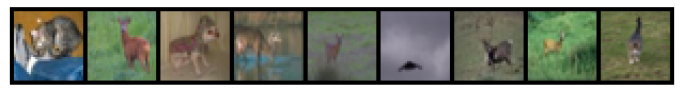

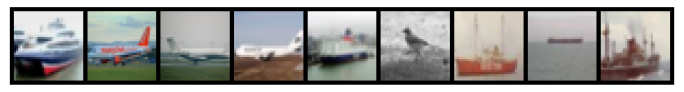

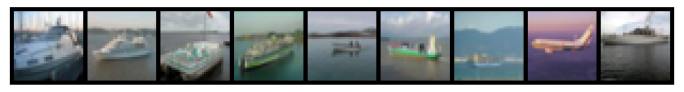

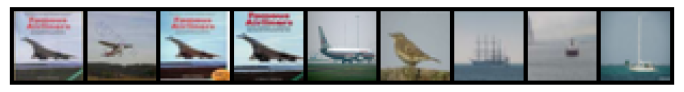

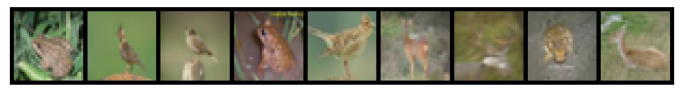

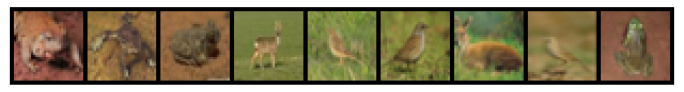

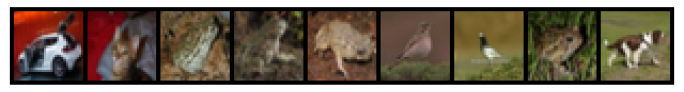

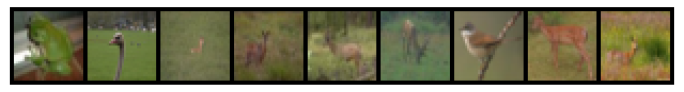

In [26]:
# Plot the closest images for the first N test images as example
for i in range(8):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)

In [27]:
# We use the following model throughout this section.
# If you want to try a different latent dimensionality, change it here!
trainer = model_dict[128]["trainer"]

In [28]:
# Create a summary writer
writer = SummaryWriter("tensorboard/")

In [29]:
## In case you obtain the following error in the next cell, execute the import statements and last line in this cell
##   AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
# Note: the embedding projector in tensorboard is computationally heavy.
# Reduce the image amount below if your computer struggles with visualizing all 10k points
NUM_IMGS = len(test_set)

writer.add_embedding(test_img_embeds[1][:NUM_IMGS], # Encodings per image
                     metadata=[test_set[i][1] for i in range(NUM_IMGS)], # Adding the labels per image to the plot
                     label_img=torch.from_numpy(test_img_embeds[0][:NUM_IMGS]+1).permute(0, 3, 1, 2)/2.0) # Adding the original images to the plot

In [ ]:
%tensorboard --logdir tensorboard/

In [33]:
# Closing the summary writer
writer.close()